In [1]:
import copy

from electrolyser_T import Electrolyser

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

In [2]:
df_I = read_csv('HASS_in_a.csv')
data_I = df_I.values
I_values = data_I[:,1]

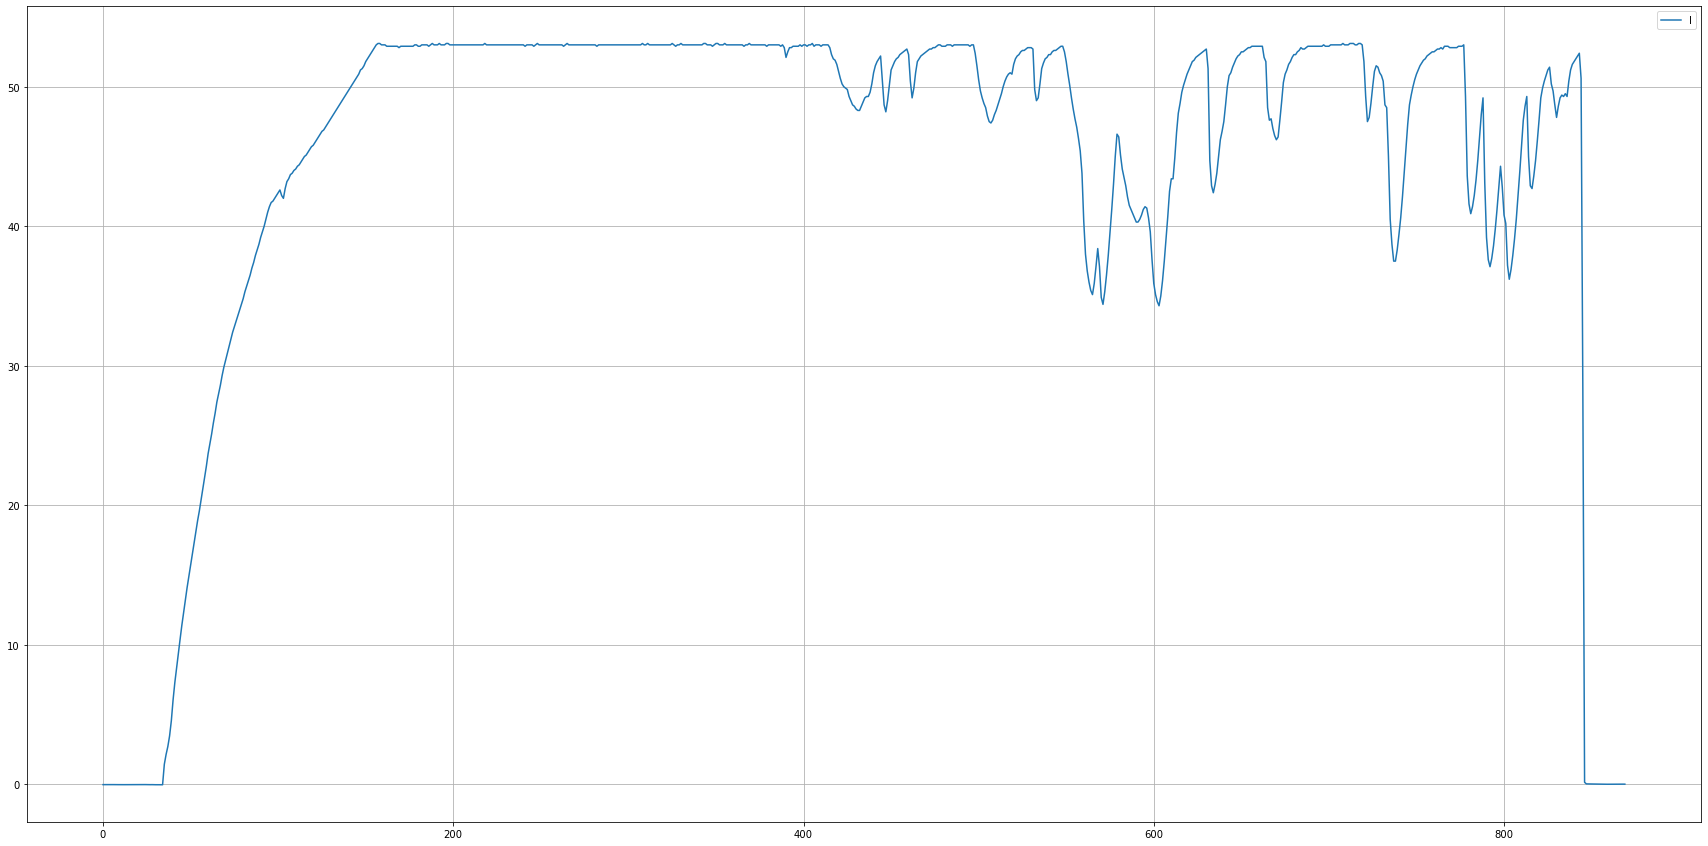

In [3]:
plt.figure(figsize=(30, 15))
plt.plot(list(range(len(I_values))), I_values, label='I')
plt.legend()
plt.grid(visible=True)
plt.show()

In [4]:
df_U = read_csv('production_rate.csv')
data_U = df_U.values
U_values = data_U[:,1]

In [5]:
for i in range(len(U_values)):
    if I_values[i] < 0.5:
        U_values[i] = 0.0

In [6]:
U_values /= (100/53)
#I_values /= 53

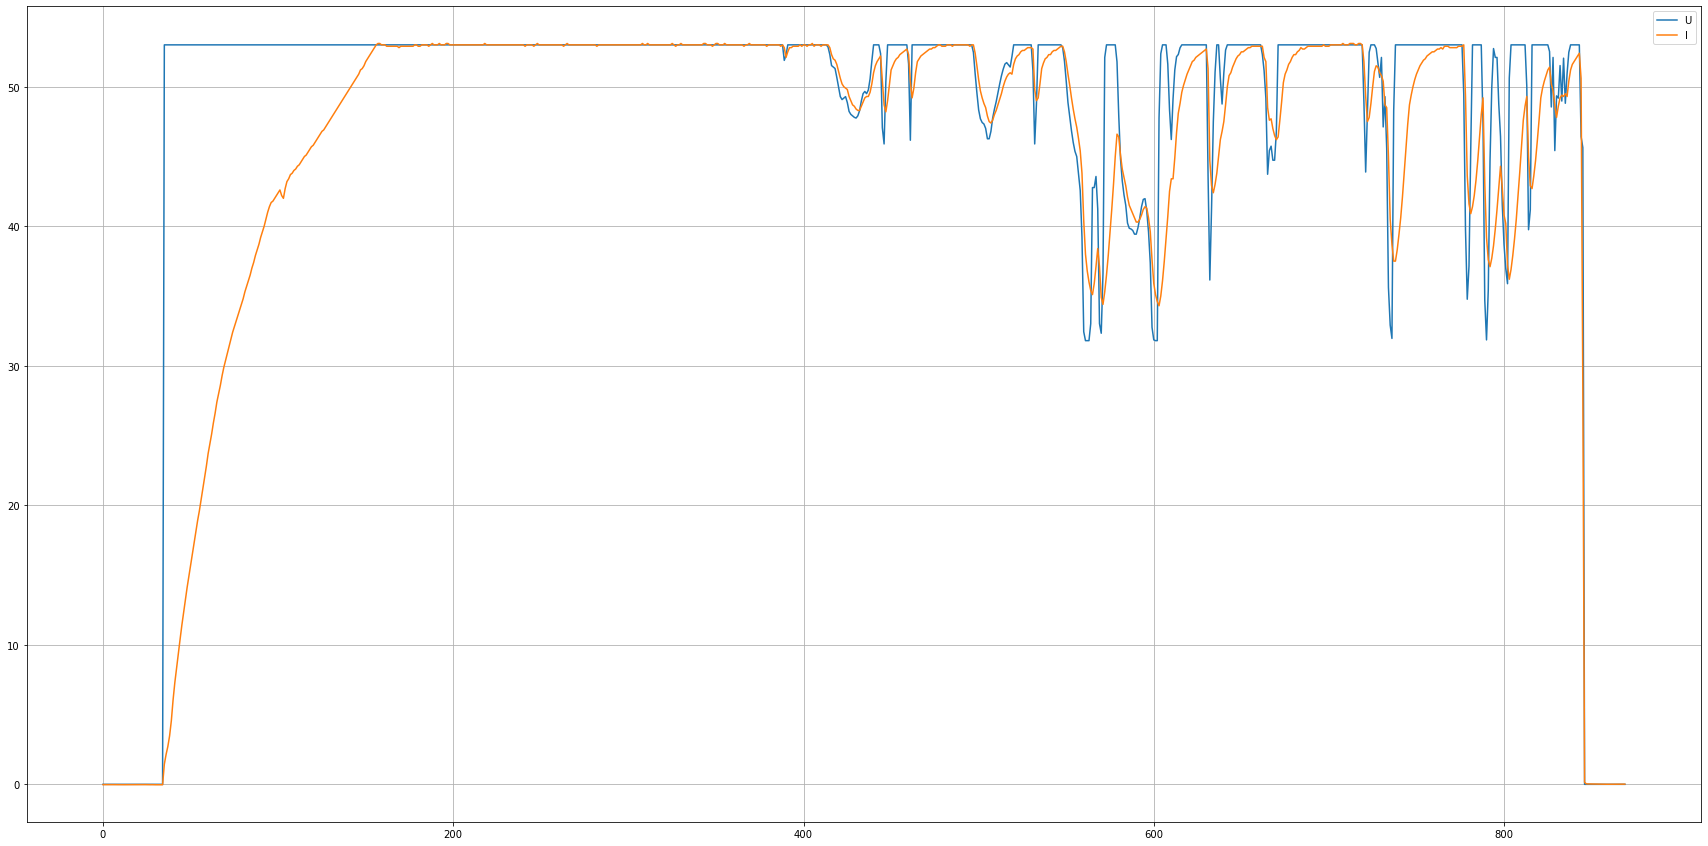

In [7]:
plt.figure(figsize=(30, 15))
plt.plot(U_values, label='U')
plt.plot(I_values, label='I')
plt.legend()
plt.grid(visible=True)
plt.show()

In [8]:
len(I_values)

870

In [9]:
from scipy import signal
from scipy import integrate

In [10]:
m = 840 # 1009 #

In [11]:
Y = I_values[:m]
U = U_values[:m]

In [12]:
delta_t = 2 #10 #0.01 # time step size (seconds)

t_max = m * delta_t

time_work = np.linspace(0, t_max, int(t_max//delta_t))

print(len(time_work))


840


# first order

In [13]:
filter = signal.lti([0, 1],[1, 1])

/home/eduard/anaconda3/lib/python3.9/site-packages/scipy/signal/filter_design.py:1631: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


In [14]:
import copy

In [15]:
f = copy.deepcopy(Y)

tout_x1, x1, Xout_x1 = signal.lsim(filter, Y, time_work)
tout_x2, x2, Xout_x2 = signal.lsim(filter, U, time_work)

In [16]:
X = np.concatenate((x1.reshape((1,m)),
                    x2.reshape((1,m))), axis=0).T

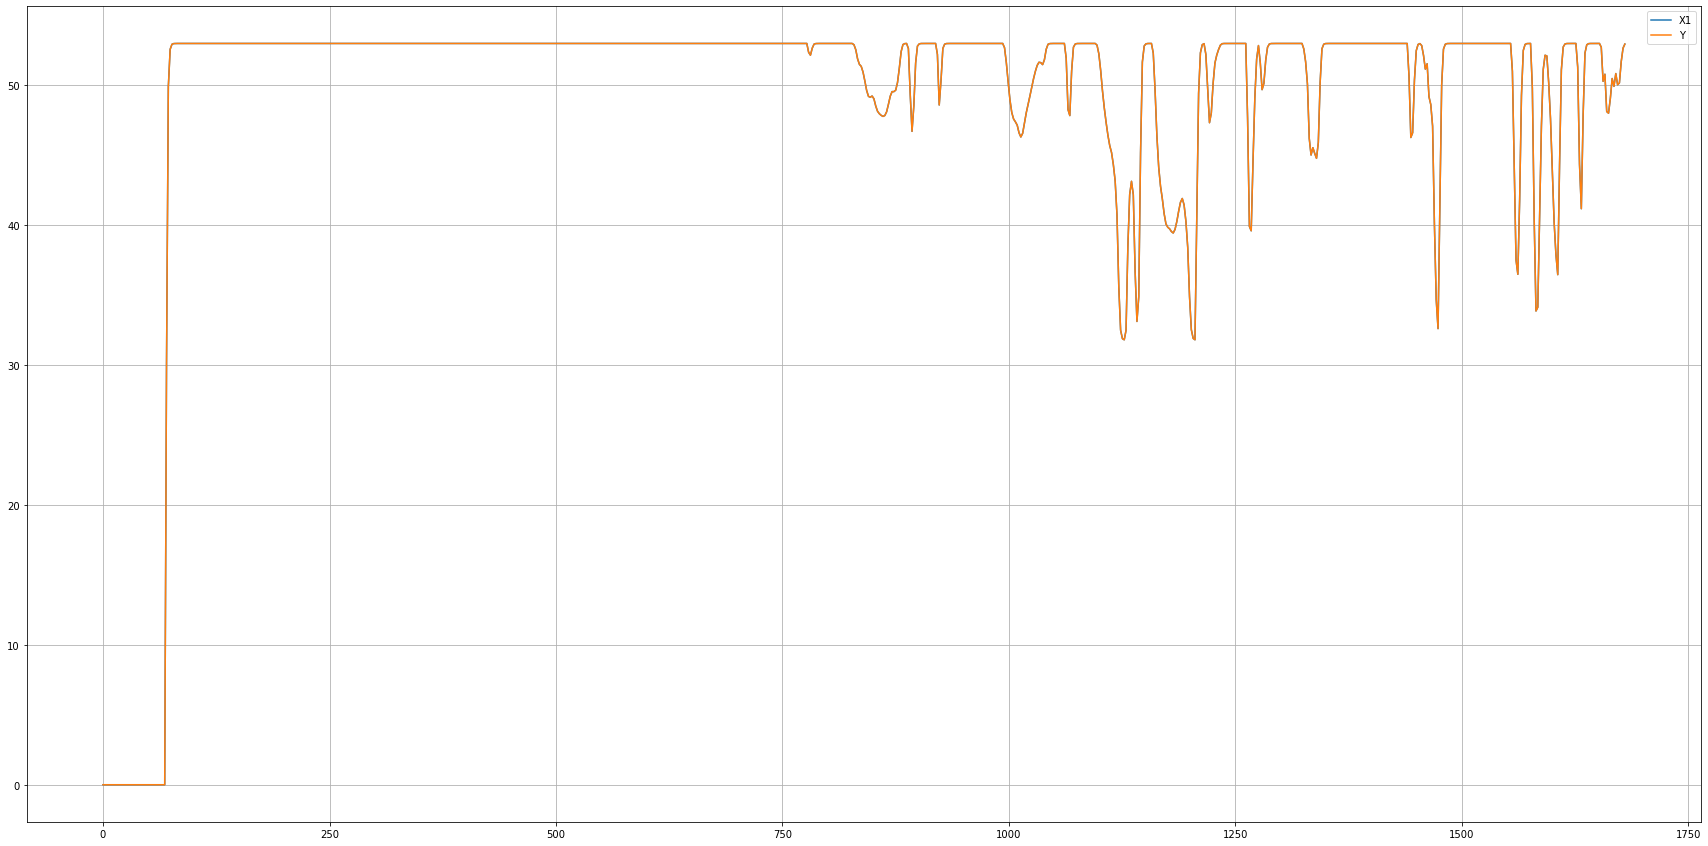

In [17]:
plt.figure(figsize=(30, 15))
plt.plot(time_work, X[:,1], label='X1')
plt.plot(time_work, x2, label='Y')
plt.legend()
plt.grid(visible=True)
plt.show()

In [18]:
from sklearn import linear_model



In [19]:
reg = linear_model.LinearRegression()
reg.fit (X, f)

LinearRegression()

In [20]:
[w1, w2] = reg.coef_ # w1 = 1-a0, w2 = b0

In [21]:
print([w1, w2])

[0.9796829609275383, 0.02558249272422137]


In [22]:
result_model = signal.lti([0, w2*53/66.7],[1, 1-w1])

/home/eduard/anaconda3/lib/python3.9/site-packages/scipy/signal/filter_design.py:1631: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


In [23]:
tout_y_model, y_model, Xout_y_model = signal.lsim( result_model, U, time_work)

In [24]:
max(y_model)

53.02834853805556

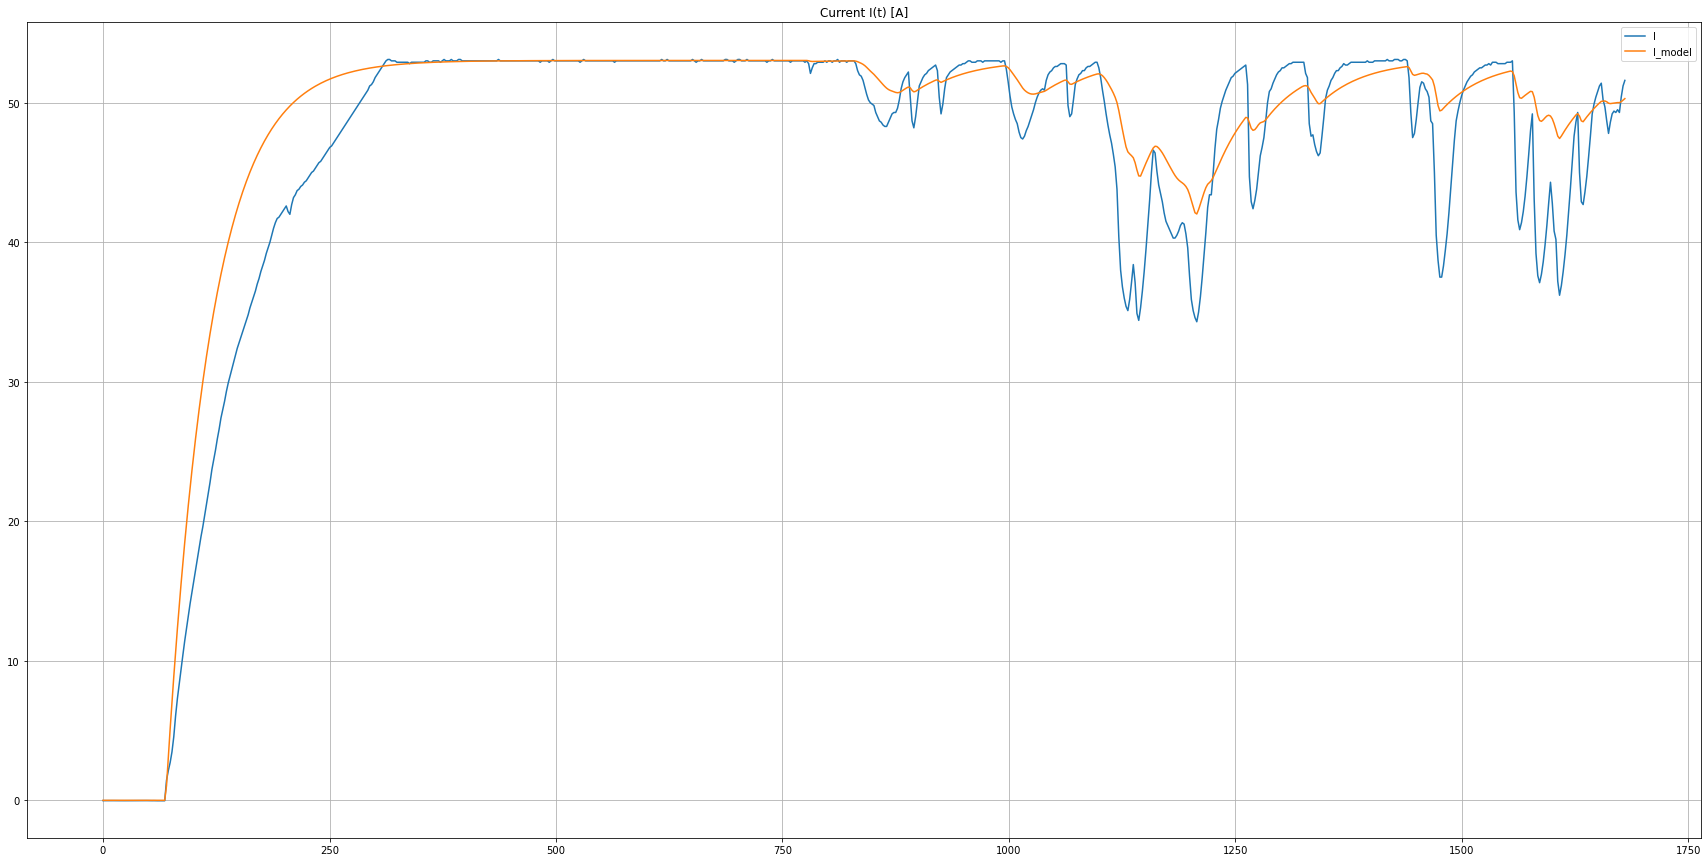

In [25]:
plt.figure(figsize=(30, 15))
plt.title("Current I(t) [A]")
plt.plot(time_work, I_values[:840], label='I')
plt.plot(time_work, y_model, label='I_model') # *53/max(y_model)
plt.legend()
plt.grid(visible=True)
plt.show()

# Diskret first order
I(k+1) = a I(k) + b I_ref(k)

In [30]:
b = w2#*53/66.7
a = 1-w1
I_d = [0]

for k in range(1, len(U)):
    I_d.append(a * I_d[k-1] + b * U[k-1])



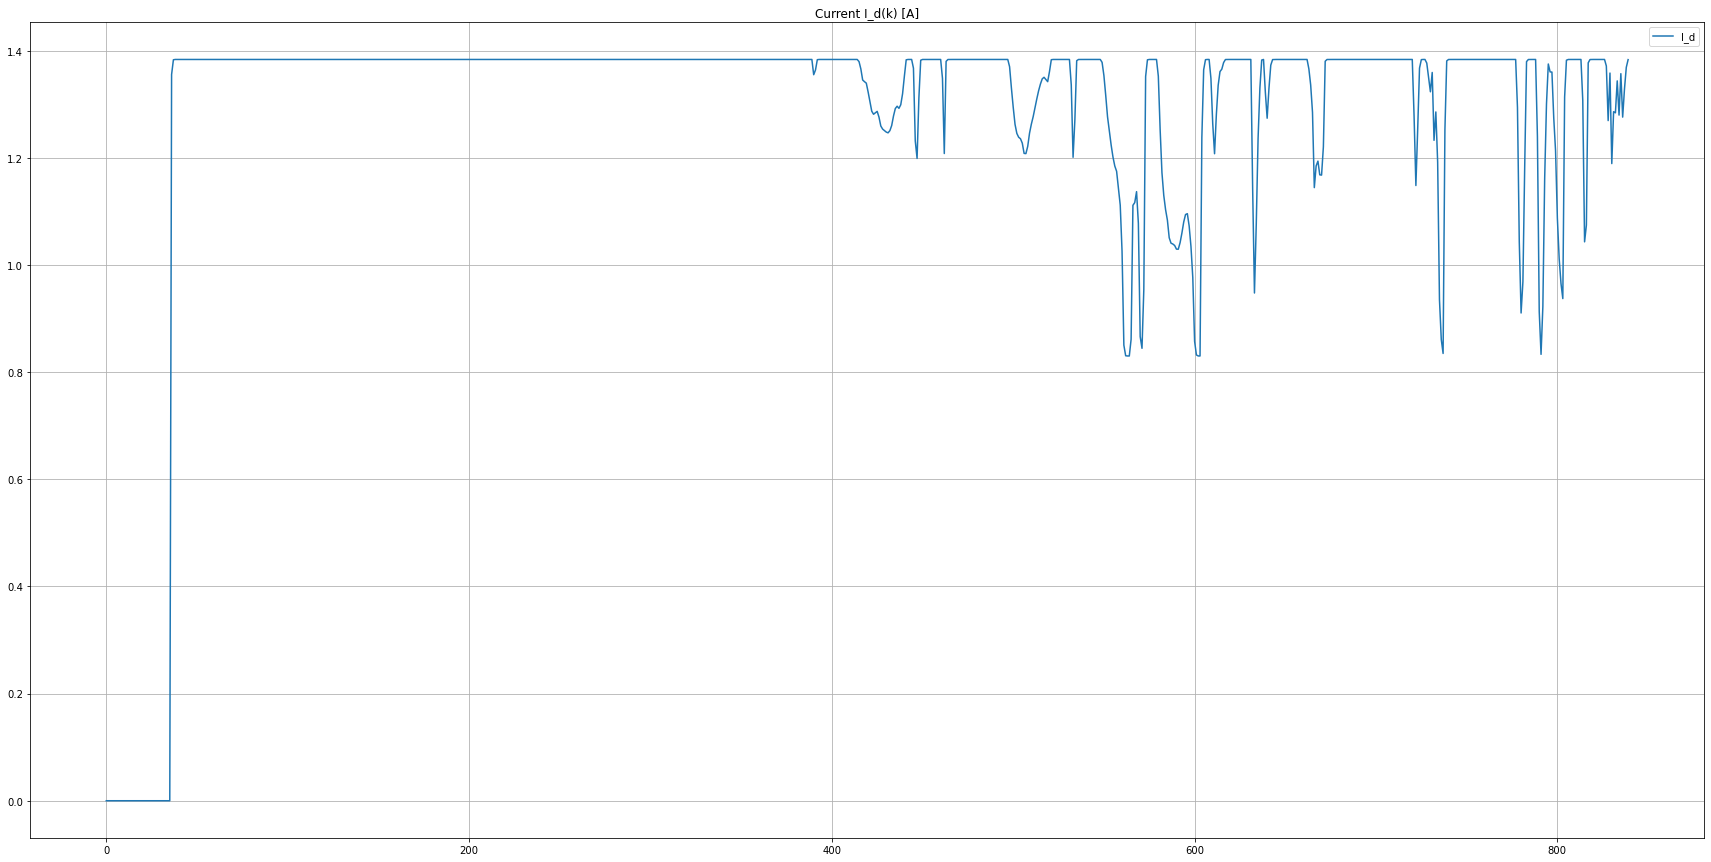

In [31]:
plt.figure(figsize=(30, 15))
plt.title("Current I_d(k) [A]")
plt.plot(I_d, label='I_d')
plt.legend()
plt.grid(visible=True)
plt.show()

# 2 oredr

In [25]:
filter1 = signal.lti([1, 0],[1, 1])
filter2 = signal.lti([1],[1, 1])
#filter3 = signal.lti([1],[1, 1])

In [26]:
tout_f, f, Xout_f = signal.lsim(filter1, Y, time_work)

tout_x1, x1, Xout_x1 = signal.lsim(filter2, Y, time_work)
tout_x2, x2, Xout_x2 = signal.lsim(filter1, U, time_work)
tout_x3, x3, Xout_x3 = signal.lsim(filter2, U, time_work)
#tout_x4, x4, Xout_x4 = signal.lsim(filter3, U, time_work)

In [27]:
X = np.concatenate((x1.reshape((1,m)),
                    x2.reshape((1,m)),
                    x3.reshape((1,m))), axis=0).T # x4.reshape((1,m))

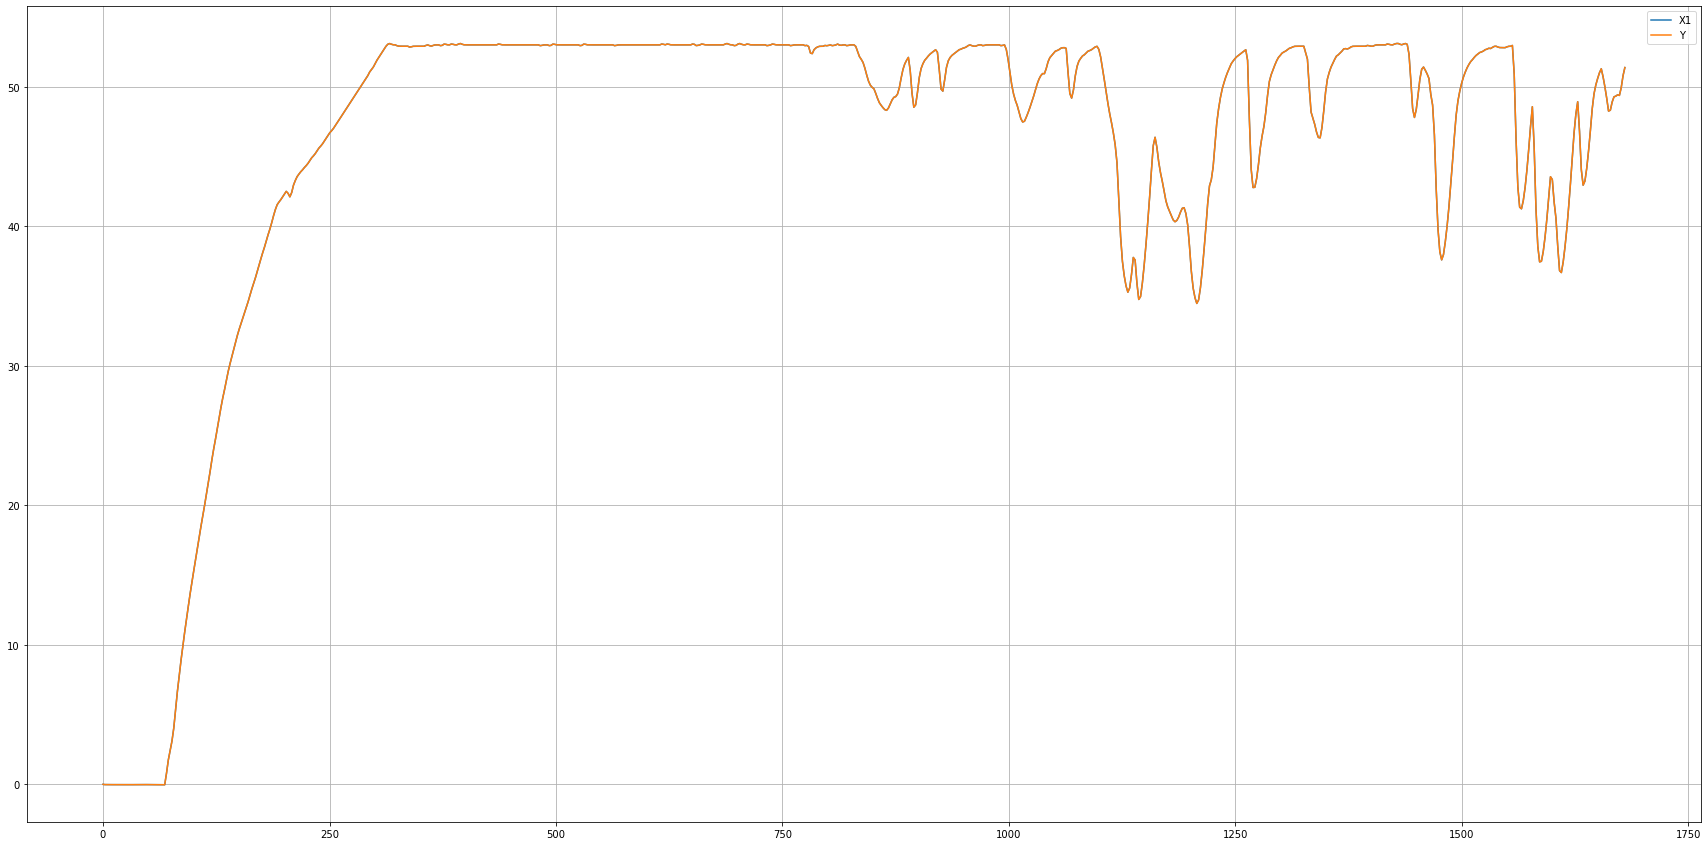

In [17]:
plt.figure(figsize=(30, 15))
plt.plot(time_work, X[:,0], label='X1')
plt.plot(time_work, x1, label='Y')
plt.legend()
plt.grid(visible=True)
plt.show()

In [18]:
from sklearn import linear_model

In [19]:

reg = linear_model.LinearRegression()
reg.fit (X, f)


LinearRegression()

In [20]:
[a1, b1, b0] = reg.coef_

In [21]:
print([a1, b1, b0])

[-0.018574406334508155, 0.06181780987784119, 0.024168318508936595]


In [33]:
result_model = signal.lti([0, b0],[1, -a1])

/home/eduard/anaconda3/lib/python3.9/site-packages/scipy/signal/filter_design.py:1631: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


In [34]:
tout_y_model, y_model, Xout_y_model = signal.lsim( result_model, U, time_work)

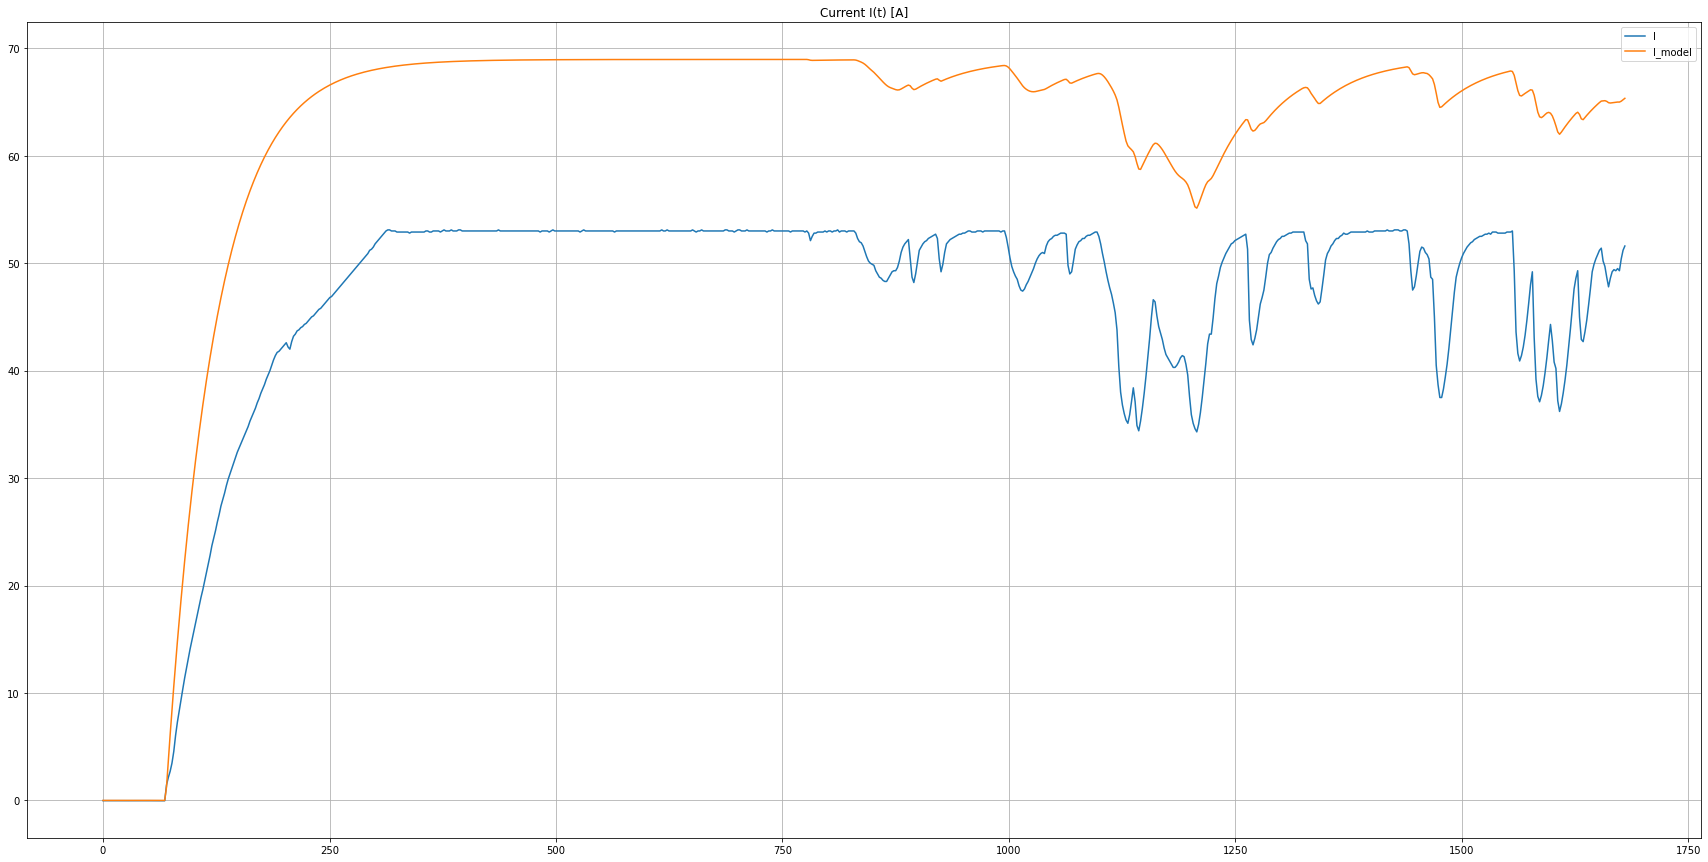

In [35]:
plt.figure(figsize=(30, 15))
plt.title("Current I(t) [A]")
plt.plot(time_work, I_values[:840], label='I')
plt.plot(time_work, y_model, label='I_model') # *53/max(y_model)
plt.legend()
plt.grid(visible=True)
plt.show()